# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras
from keras.models import Model
from keras.datasets import cifar10
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import adam, sgd, adagrad
from keras.utils import to_categorical

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train, flatten=False)
x_test = preproc_x(x_test, flatten=False)
img_shape = x_train.shape[1:]

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_cnn(input_shape):
    input_layer = Input(input_shape)
    conv1 = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(input_layer)
    pool1 = MaxPool2D()(conv1)
    conv2 = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(pool1)
    pool2 = MaxPool2D()(conv2)
    flat = Flatten()(pool2)
    full_con = Dense(units=256, activation='relu')(flat)
    full_con = Dense(units=256, activation='relu')(full_con)
    output = Dense(units=10, activation='softmax')(full_con)
    
    model = Model(inputs=[input_layer], outputs=[output])
    
    return model

model = build_cnn(img_shape)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
__________

In [6]:
## 超參數設定
"""
Set your required experiment parameters
"""
MOMENTUM = 0.95
LEARNING_RATE = [1e-3, 1e-4, 1e-5]
BATCH_SIZE = 256
EPOCHS = 5

optimizer_dict = {'Adam': {'optimizer': adam, 'parameter': {}},
                 'Adagrad': {'optimizer': adagrad, 'parameter': {}},
                 'SGD': {'optimizer': sgd, 'parameter': {'momentum': MOMENTUM, 'nesterov': True}}}

In [7]:
results = {}
for name, opt_ in optimizer_dict.items():
    opt = opt_['optimizer']
    parameters = opt_['parameter']
    
    for lr in LEARNING_RATE:
        keras.backend.clear_session()
        model = build_cnn(img_shape)
        optimizer = opt(**parameters, lr=lr)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        
        print('Train CNN by optimizer: {}, lr: {}'.format(name, str(lr)))
        history = model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                            validation_data=(x_test, y_test), shuffle=True)
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "{}-lr-{}".format(name, str(lr))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Train CNN by optimizer: Adam, lr: 0.001
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 30s 606us/step - loss: 1.5769 - acc: 0.4357 - val_loss: 1.3519 - val_acc: 0.5215
Epoch 2/5
50000/50000 [==============================] - 31s 621us/step - loss: 1.1754 - acc: 0.5822 - val_loss: 1.1460 - val_acc: 0.5944
Epoch 3/5
50000/50000 [==============================] - 31s 612us/step - loss: 1.0054 - acc: 0.6463 - val_loss: 1.0067 - val_acc: 0.6415
Epoch 4/5
50000/50000 [==============================] - 31s 612us/step - loss: 0.8732 - acc: 0.6942 - val_loss: 0.9685 - val_acc: 0.6622
Epoch 5/5
50000/50000 [==============================] - 30s 610us/step - loss: 0.7769 - acc: 0.7283 - val_loss: 1.0096 - val_acc: 0.6475
Train CNN by optimizer: Adam, lr: 0.0001
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 31s 615us/step - loss: 1.9043 - acc: 0.3321 - val_loss: 1.7069 - val_acc

In [10]:
import pickle

with open('data/Day80_result.pkl', 'wb') as wf:
    pickle.dump(results, wf)

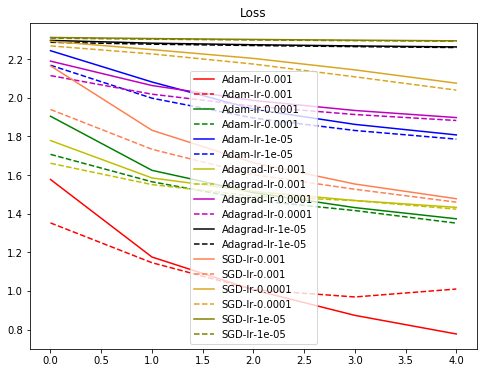

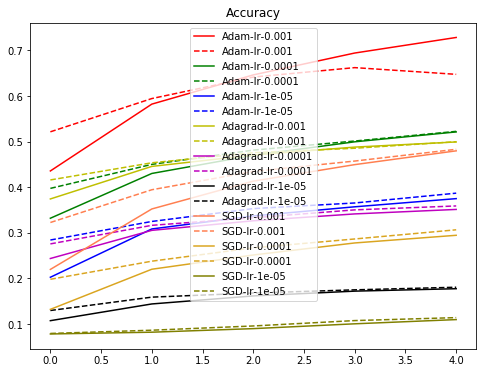

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k", "coral", "goldenrod", "olive"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()